### Постановка задачи
Определять породу собаки по фотографии. Протестировать полученную модель на отложенной выборке и на аугментированных изображениях.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import albumentations as A
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, ReLU
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy, top_k_categorical_accuracy
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm_notebook
%matplotlib inline

### 1. Используемые библиотеки
- `numpy` - работа с многомерными массивами
- `pandas` - считывание и обработка `.csv` файлов
- `matplotlib` - вывод изображений
- `tensorflow/keras` - фреймворк для создания и обучения нейросетей
- `albumentations` - фреймворк для создания аугментированных изображений
- `tqdm` - прогресс-бар
<img src="./src/tf_keras.jpeg">

In [2]:
IMG_SHAPE = (224, 224)
NUM_BREEDS = 120
TRAIN_SIZE = 3200

### 2. Считывание изображений и создание датасета

Используемый датасет - подмножество ImageNet, расширенное изображениями <a href="http://vision.stanford.edu/aditya86/ImageNetDogs/">Stanford Dogs Dataset</a>

In [3]:
def read_img(img_id, size, train=True):
    if train:
        img = image.load_img(f'./data/train/{img_id}.jpg', target_size=size)
    else:
        img = image.load_img(f'./data/test/{img_id}.jpg', target_size=size)
    img = image.img_to_array(img)
    return img

In [4]:
labels = pd.read_csv('./data/labels.csv')

breed_to_idx = dict()
idx_to_breed = []
for idx, breed in enumerate(set(labels.breed)):
    idx_to_breed.append(breed)
    breed_to_idx[breed] = idx

assert len(idx_to_breed) == NUM_BREEDS, 'Количество классов не равно ожидаемому'

Порода - flat-coated_retriever


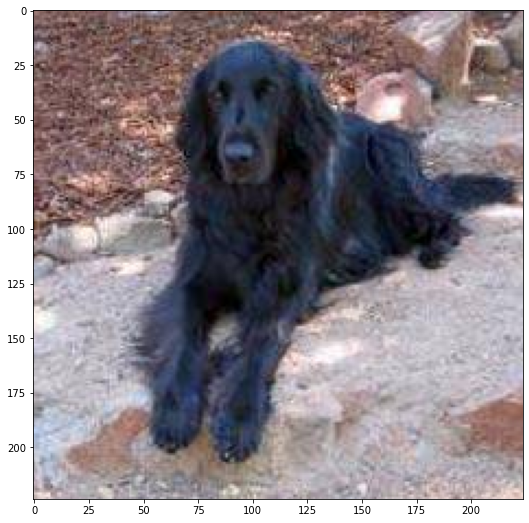

In [5]:
t = np.random.randint(labels.shape[0])
img = read_img(labels.id[t], IMG_SHAPE)
print(f'Порода - {labels.breed[t]}')
plt.figure(figsize=(9, 9))
plt.imshow(img / 255);

In [6]:
def load_images(target_size=IMG_SHAPE, max_read=None):
    X = []
    y = []
    if not max_read:
        max_read = labels.shape[0]
    for _, (imageid, breed) in tqdm_notebook(labels[:max_read].iterrows(), total=max_read):
        img = read_img(imageid, target_size)
        X.append(img)
        y.append(breed_to_idx[breed])
    return np.array(X), np.array(y)

In [7]:
X, y = load_images(max_read=TRAIN_SIZE) # считываем TRAIN_SIZE изображений
X_train = preprocess_input(X)  # Стандартизация изображений
y_train = to_categorical(y, num_classes=NUM_BREEDS)  # Преобразование в one-hot вектор

print(f'Размер обучающих изображений = {X_train.shape}')
print(f'Размер обучающей разметки = {y_train.shape}')

del X, y  # Освобождаем память


Размер обучающих изображений = (3200, 224, 224, 3)
Размер обучающей разметки = (3200, 120)


### 3. Архитектура нейросети
Для классификации воспользуемся архитектурой ???. \
https://arxiv.org/abs/1801.04381 

Предыдущая версия V1: \
https://arxiv.org/abs/1704.04861 

<img src="./src/v1_v2.png">

Особенности:
- Маленький размер (всего лишь ~15 мегабайт)
- Новые формы блоков
<img src="./src/v2_vis.png">
<img src="./src/v2_text.png">
- Функция активации `relu6`
<img src="./src/relu6.png">

In [8]:
base_model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [9]:
X_train_embeddings = base_model.predict(X_train)
del X_train

In [10]:
X_train_embeddings.shape

(3200, 7, 7, 1280)

In [11]:
head_input = Input(shape=(7, 7, 1280))
x = GlobalAveragePooling2D()(head_input)
x = Dense(units=128, activation=ReLU(max_value=6))(x)
# x = Dense(units=128, activation='sigmoid')(x)
outputs = Dense(NUM_BREEDS, activation='softmax')(x)

head_model = Model(inputs=head_input, outputs=outputs)

#### Выбор метрики.
Будем ориентироваться на такую метрику как top-3 accuracy, которая показывает, соответствует ли метка с одним из трех самых вероятных классов, предсказанных моделью. Выбор метрики обусловлен тем, что многие породы собак объединяются в группы пород (Миттельшнауцер, Цвергшнауцер, Ризеншнауцер образуют группу Шнауцеров).

### 4. Дообучение (fine-tuning) сети
Чтобы дообучить сеть на имеющемся датасете необходимо:
1. Заморозить слои базовой сети, чтобы они не обновлялись
2. Выбрать функцию потерь и optimizer (adam), выбрать метрику для отслеживания
3. Обучить сеть на имеющемся датасете

Дополнительно можно:
4. Разморозить все веса
5. Еще раз обучить сеть с очень маленькой скоростью обучения (learning rate)

In [12]:
head_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy', TopKCategoricalAccuracy(k=2)])

In [13]:
head_model.fit(X_train_embeddings, y_train, batch_size=64, epochs=5)

Train on 3200 samples
Epoch 1/5
3200/3200 [==============================] - 3s 1ms/sample - loss: 3.5590 - accuracy: 0.2591 - top_k_categorical_accuracy: 0.3578 2s - loss: 4.3696 - accuracy: 0.1003 - top_k_categorical_accu
Epoch 2/5
3200/3200 [==============================] - 1s 362us/sample - loss: 1.1661 - accuracy: 0.7216 - top_k_categorical_accuracy: 0.8569
Epoch 3/5
3200/3200 [==============================] - 1s 424us/sample - loss: 0.6117 - accuracy: 0.8481 - top_k_categorical_accuracy: 0.9466s - loss: 0.6514 - accuracy: 0.8438 - top_k_categorical
Epoch 4/5
3200/3200 [==============================] - 1s 430us/sample - loss: 0.3997 - accuracy: 0.9141 - top_k_categorical_accuracy: 0.9756s - loss: 0.3916 - accuracy: 0.9250 - top_k_categoric
Epoch 5/5
3200/3200 [==============================] - 1s 406us/sample - loss: 0.2726 - accuracy: 0.9534 - top_k_categorical_accuracy: 0.9881s - loss: 0.2673 - accuracy: 0.9562 - top_k_categorical_accuracy: 


In [14]:
base_out = base_model.output

full_out = head_model(base_out)
model = Model(inputs=base_model.input, outputs=full_out)

In [15]:
del X_train_embeddings, y_train

### 5. Тестирование в интерактивном режиме

pug - 0.788
french_bulldog - 0.066
bull_mastiff - 0.060


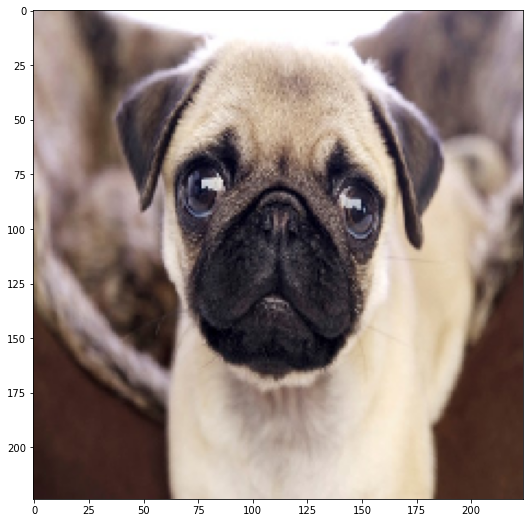

In [16]:
img = read_img('1', size=IMG_SHAPE, train=False)

plt.figure(figsize=(9, 9))
plt.imshow(img / 255);

img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

preds = model.predict(img)[0]

for dog_idx in preds.argsort()[-1:-4:-1]:
    breed = idx_to_breed[dog_idx]
    pr = preds[dog_idx]
    print(f'{breed} - {pr:.3f}')

### 6. Тестирование на отложенной выборке
Возьмем последние 2000 изображений в датасете и посчитаем на них метрики

In [17]:
num_last = 2000
X_test = []
y_test = []
for _, (imageid, breed) in tqdm_notebook(labels[-num_last:].iterrows(), total=num_last):
    img = read_img(imageid, IMG_SHAPE)
    X_test.append(img)
    y_test.append(breed_to_idx[breed])
X_test = preprocess_input(np.array(X_test))
y_test = to_categorical(np.array(y_test))

In [18]:
probs = model.predict(X_test)

In [19]:
top3_acc = top_k_categorical_accuracy(y_test, probs, k=3).numpy()
print(f'На тестовой выборке\nTop-3 accuracy: {top3_acc.sum() / top3_acc.shape[0]}')

top1_acc = top_k_categorical_accuracy(y_test, probs, k=1).numpy()
print(f'На тестовой выборке\nTop-1 accuracy: {top1_acc.sum() / top1_acc.shape[0]}')

На тестовой выборке
Top-3 accuracy: 0.9185
На тестовой выборке
Top-1 accuracy: 0.733


In [20]:
def read_img(img_id, size, train=True, transform=None):
    if train:
        img = image.load_img(f'./data/train/{img_id}.jpg', target_size=size)
    else:
        img = image.load_img(f'./data/test/{img_id}.jpg', target_size=size)
    img = image.img_to_array(img, dtype=np.uint8)
    if transform is not None:
        img = transform(image=img, )['image']
    return img

In [21]:
augmentations = [
    A.NoOp(always_apply=True),
    A.GaussianBlur(blur_limit=(5, 9), always_apply=True),
    A.MedianBlur(blur_limit=9, always_apply=True),
    A.RGBShift(always_apply=True),
    A.HueSaturationValue(always_apply=True),
    A.ChannelShuffle(always_apply=True),
    A.CLAHE(always_apply=True),
    A.RandomContrast(always_apply=True),
    A.RandomBrightness(always_apply=True),
    A.ToGray(always_apply=True),
    A.JpegCompression(quality_lower=20, quality_upper=20, always_apply=True),
    A.ElasticTransform(always_apply=True)
]
aug_names = ['Оригинальное изображение', "Гауссовское размытие",
             'Медианное размытие', 'RGB-сдвиг',
             'HSV-сдвиг', 'Перемешивание каналов',
             'CLAHE', 'Изменение контраста',
             'Изменения яркости', 'Оттенки серого',
             'JPEG-сжатие', 'Эластичная трансформация', 
            ]
print(len(augmentations))

12


In [22]:
img_examples = []
transforms_accuracy = []

num_img_display = -90
num_last = 800
for transform in tqdm_notebook(augmentations):
    X_test = []
    y_test = []
    for _, (imageid, breed) in labels[-num_last:].iterrows():
        img = read_img(imageid, IMG_SHAPE, transform=transform)
        X_test.append(img)
        y_test.append(breed_to_idx[breed])
    img_examples.append(X_test[num_img_display])
    X_test = preprocess_input(np.array(X_test))
    y_test = to_categorical(np.array(y_test))

    probs = model.predict(X_test)
    top1_acc = top_k_categorical_accuracy(y_test, probs, k=1).numpy()
    transforms_accuracy.append(top1_acc.sum() / top1_acc.shape[0])

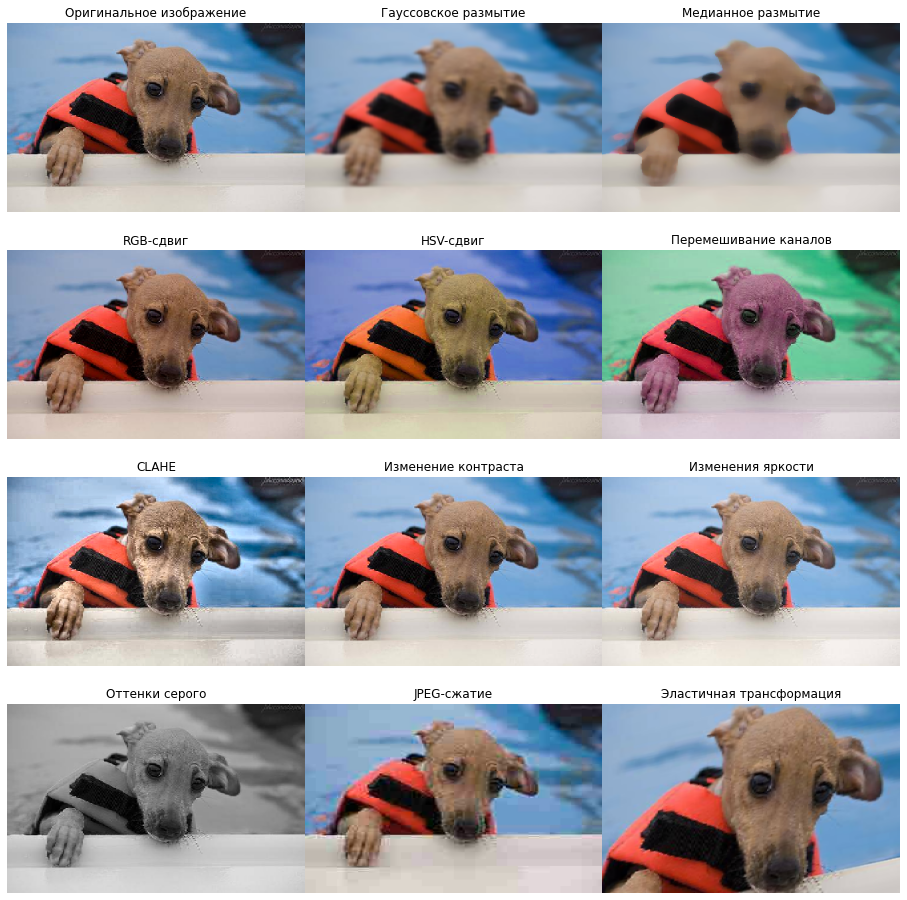

In [23]:
f, ax = plt.subplots(4, 3, figsize=(16, 16))
for row in range(4):
    for col in range(3):
        ax[row, col].imshow(img_examples[col + row * 3], aspect='auto')
        ax[row, col].axis('off')
        ax[row, col].set_title(aug_names[col + row * 3])
plt.subplots_adjust(wspace=0, hspace=.2)
plt.savefig('augmentations.png', bbox_inches='tight')
plt.show()

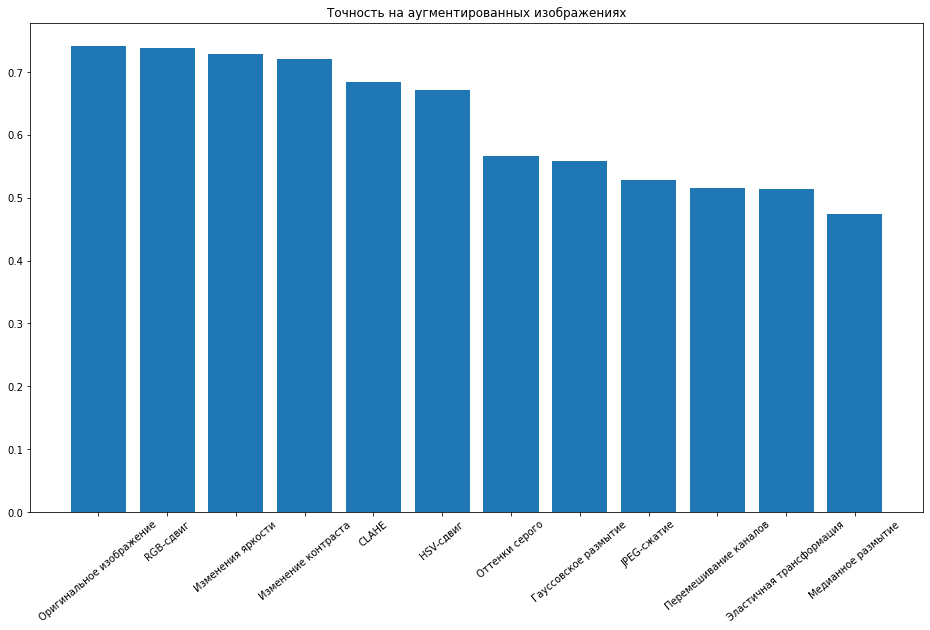

In [24]:
order = np.argsort(transforms_accuracy)[::-1]
plt.figure(figsize=(16, 9))
plt.xticks(rotation=40)
plt.title('Точность на аугментированных изображениях')
plt.bar(np.array(aug_names)[order], np.array(transforms_accuracy)[order])
plt.savefig('aug_accuracy.png', bbox_inches='tight')
plt.show()